In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/iss/PRS/PM/')
!ls

import sys
sys.path.append('/content/gdrive/MyDrive/iss/PRS/PM/vision/references/detection')

Mounted at /content/gdrive
 archive			       maskrcnn-benchmark-main
 checkpoin			       mask_rcnn_coco.h5
 checkpoint			       my_data
 COVID-CT-Mask-Net-master	       my_data2
 ct_lesion_seg.zip		       __pycache__
'ct_lesion_seg.zip (Unzipped Files)'   Untitled0.ipynb
 ct_seg_model.pth		       Untitled1.ipynb
 data				      'Untitled2(dont need).ipynb'
 lesion_mask_data_process.ipynb        Untitled2.ipynb
 lung_mask_data			       Untitled3.ipynb
 lung_mask_model.pth		       Untitled4.ipynb
 lung_mask_model_train.ipynb	       Untitled5.ipynb
 marchine_learning.ipynb	       vision
 MASK_RCNN


In [2]:
import torch
print("PyTorch version is", torch.__version__)

PyTorch version is 1.9.0+cu111


In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

# im = cv2.imread('ct_lesion_seg/mask/8/28.png')
# obj_ids = np.unique(im)

# for k in range(3):
#   for i in range(im.shape[0]):
#     for j in range(im.shape[1]):
#       if(im[i][j][k] == 1):
#         im[i][j][k] = 255

# cv2_imshow(im)

# im2 = cv2.imread('ct_lesion_seg/image/8/28.jpg')
# cv2_imshow(im2)

In [ ]:
# # Jeremy: some masks dont have lesion, remove them

# counter = 0
# mask_list = []
# folder_list = []
# folder_list = list(sorted(os.listdir(os.path.join('ct_lesion_seg', "mask"))))
# for i in folder_list:
#   mask_list.append(list(sorted(os.listdir(os.path.join('ct_lesion_seg', "mask", i)))))

# for i in range(150):
#   for j in mask_list[i]:
#     mask_path = os.path.join('ct_lesion_seg', "mask", folder_list[i], j)
#     mask = Image.open(mask_path)
#     mask = np.array(mask)
#     obj_ids = np.unique(mask)[2:]
#     if(len(obj_ids) == 0):
#       os.remove(mask_path)
#     else:
#       counter = counter + 1
  

In [ ]:
from skimage.measure import label as method_label
from skimage.measure import regionprops
import numpy as np

import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread('ct_lesion_seg/mask/0/46.png')
obj_ids = np.unique(im)

obj_ids = obj_ids[2:]

# for k in range(3):
#   for i in range(im.shape[0]):
#     for j in range(im.shape[1]):
#       if(im[i][j][k] == 1):
#         im[i][j][k] = 255
#       elif(im[i][j][k] == 2):
#         im[i][j][k] = 50
#       elif(im[i][j][k] == 3):
#         im[i][j][k] = 150

# cv2_imshow(im)

# im2 = cv2.imread('ct_lesion_seg/image/0/46.jpg')
# cv2_imshow(im2)

masks = im == obj_ids[:, None, None]

print(masks.shape)

KeyboardInterrupt: ignored

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from skimage.measure import label as method_label
from skimage.measure import regionprops

class Ct_seg_dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.folders = list(sorted(os.listdir(os.path.join(self.root, "image"))))
        self.masks = []

        for i in self.folders:
          self.masks.append(list(sorted(os.listdir(os.path.join(self.root, "mask", i)))))
        
        self.idx_list = []
        for i in range(len(self.masks)):
          for j in range(len(self.masks[i])):
            self.idx_list.append([i, j])
    
    def extract_single_mask(self, mask, lab):
        _mask = np.zeros(mask.shape, dtype=np.uint8)
        area = mask == lab
        _mask[area] = 1
        return _mask
        

    def __getitem__(self, idx):
        # load images and masks
        mask_i = self.idx_list[idx][0]
        mask_j = self.idx_list[idx][1]
        # Jeremy: change 'xxx.png' to 'xxx.jpg'
        img_name = "".join(list(filter(str.isdigit, self.masks[mask_i][mask_j])))+'.jpg'
        img_path = os.path.join(self.root, "image", self.folders[mask_i], img_name)
        mask_path = os.path.join(self.root, "mask", self.folders[mask_i], self.masks[mask_i][mask_j])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        # Jeremy: also remove second id becaues it is the lung shape in our dataset
        obj_ids = obj_ids[2:]

        # split the color-encoded mask into a set
        # of binary masks
        mask_classes = mask == obj_ids[:, None, None]

        # # get bounding box coordinates for each mask
        # num_objs = len(obj_ids)
        # boxes = []
        # for i in range(num_objs):
        #     pos = np.where(masks[i])
        #     xmin = np.min(pos[1])
        #     xmax = np.max(pos[1])
        #     ymin = np.min(pos[0])
        #     ymax = np.max(pos[0])
        #     boxes.append([xmin, ymin, xmax, ymax])

        boxes = []
        masks = []
        labels = []
        for _idx, m in enumerate(mask_classes):
            lab_mask = method_label(m)
            regions = regionprops(lab_mask)
            for _i, r in enumerate(regions):
                # get rid of really small ones:
                if r.area > 1:
                    box_coords = (r.bbox[1], r.bbox[0], r.bbox[3], r.bbox[2])
                    boxes.append(box_coords)
                    labels.append(_idx + 1)
                    # create a mask for one object, append to the list of masks
                    mask_obj = self.extract_single_mask(lab_mask, r.label)
                    masks.append(mask_obj)        

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])


        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.ones((len(masks),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.idx_list)

In [ ]:
# prepare backbone
from torch import nn
from torchvision.models import resnet
from torchvision.models._utils import IntermediateLayerGetter
from collections import OrderedDict
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


class BackboneWithFPN(nn.Sequential):
    """
    Adds a FPN on top of a model.

    Internally, it uses torchvision.models._utils.IntermediateLayerGetter to
    extract a submodel that returns the feature maps specified in return_layers.
    The same limitations of IntermediatLayerGetter apply here.

    Arguments:
        backbone (nn.Module)
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).
        in_channels_list (List[int]): number of channels for each feature map
            that is returned, in the order they are present in the OrderedDict
        out_channels (int): number of channels in the FPN.

    Attributes:
        out_channels (int): the number of channels in the FPN
    """
    def __init__(self, backbone, return_layers, in_channels_list, out_channels):
        body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            # Alex: delete the additional block
            # FPN outputs a single layer
            #extra_blocks=LastLevelMaxPool(),
        )
        super(BackboneWithFPN, self).__init__(OrderedDict(
            [("body", body), ("fpn", fpn)]))
        self.out_channels = out_channels

def resnet_fpn_backbone(backbone_name, pretrained, out_ch, truncation):

    
    backbone = resnet.__dict__[backbone_name](
        pretrained=pretrained,
        norm_layer=nn.BatchNorm2d)
    
    # Alex: the orginial implementation uses 4 outputs from the backbone
    # to replicate the best results in the paper, use resnet18 or resnet34
    # and truncation=1 or resnet50 and truncation=0 for the large model
    
    if backbone_name == 'resnet50':
       return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}
       in_channels_stage2 = 256
       in_channels_list = [
          in_channels_stage2,
          in_channels_stage2 * 2,
          in_channels_stage2 * 4,
          in_channels_stage2 * 8,
      ]
    elif backbone_name == 'resnet18' or backbone_name == 'resnet34':   
       if truncation == '0':
          return_layers = {'layer4':0}
       elif truncation == '1':
          return_layers = {'layer3':0}
       elif truncation == '2':
          return_layers = {'layer2':0}
       # Alex: I added the feature that returns the number of channels from the last layer in the net
       in_channels_list = [256]
       
    # These should be 256
    out_channels = out_ch
    
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)


In [ ]:
# Try to build a maskrcnn network as Alex
# Need to define backbone, rpn_anchor_generator, rpn_head, box_roi_pool, box_head, box_predictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import TwoMLPHead
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNHeads
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNN

maskrcnn_args = {'min_size': 512, 'max_size': 1024, 'rpn_batch_size_per_image': 256, 'rpn_positive_fraction': 0.75,
                  'box_positive_fraction': 0.75, 'box_fg_iou_thresh': 0.75, 'box_bg_iou_thresh': 0.5,
                  'num_classes': None, 'box_batch_size_per_image': 256, 'rpn_nms_thresh': 0.75}
# rpn_anchor_generator
anchor_generator = AnchorGenerator(
    sizes=tuple([(2, 4, 8, 16, 32) for r in range(5)]),
    aspect_ratios=tuple([(0.1, 0.25, 0.5, 1, 1.5, 2) for rh in range(5)]))


# box_head
box_head = TwoMLPHead(in_channels=256*7*7,representation_size=128)
#Backbone->FPN->boxhead->boxpredictor
box_predictor = FastRCNNPredictor(in_channels=128, num_classes=3)
maskrcnn_heads = MaskRCNNHeads(in_channels=256, layers=(128,), dilation=1)
mask_predictor = MaskRCNNPredictor(in_channels=128, dim_reduced=128, num_classes=3)



maskrcnn_args['box_head'] = box_head
maskrcnn_args['rpn_anchor_generator'] = anchor_generator
maskrcnn_args['mask_head'] = maskrcnn_heads
maskrcnn_args['mask_predictor'] = mask_predictor
maskrcnn_args['box_predictor'] = box_predictor

backbone = resnet_fpn_backbone('resnet18', False, out_ch=256, truncation='1')

model = MaskRCNN(backbone, 3, maskrcnn_args)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torchvision.models.detection import FasterRCNN

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.6 MB/s eta 0:10:18tcmalloc: large alloc 1147494400 bytes == 0x555ea645e000 @  0x7f499be5d615 0x555e6cee64cc 0x555e6cfc647a 0x555e6cee92ed 0x555e6cfdae1d 0x555e6cf5ce99 0x555e6cf579ee 0x555e6ceeabda 0x555e6cf5cd00 0x555e6cf579ee 0x555e6ceeabda 0x555e6cf59737 0x555e6cfdbc66 0x555e6cf58daf 0x555e6cfdbc66 0x555e6cf58daf 0x555e6cfdbc66 0x555e6cf58daf 0x555e6ceeb039 0x555e6cf2e409 0x555e6cee9c52 0x555e6cf5cc25 0x555e6cf579ee 0x555e6ceeabda 0x555e6cf59737 0x555e6cf579ee 0x555e6ceeabda 0x555e6cf58915 0x555e6ceeaafa 0x555e6cf58c0d 0x555e6cf579ee
     |██████████████████▌             | 1055.7 MB 1.4 MB/s eta 0:09:08tcmalloc: large alloc 1434370048 bytes == 0x555eeaab4000 @  0x7f499be5d615 0x555e6cee64cc 0x555e6cfc647a 0x555e6cee92ed 0x555e6cfdae1d 0x555e6cf5ce99 0x555e6cf579ee 0x555e6ceeabda 0x555e6cf5cd00 0x555e6cf579ee 0x555e6ceeabda 0x555e6cf59737 0x555e6cfdbc66 0x555e

In [ ]:
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [ ]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=({'min_size': 512, 'max_size': 1024, 'rpn_batch_size_per_image': 256, 'rpn_positive_fraction': 0.75, 'box_positive_fraction': 0.75, 'box_fg_iou_thresh': 0.75, 'box_bg_iou_thresh': 0.5, 'num_classes': None, 'box_batch_size_per_image': 256, 'rpn_nms_thresh': 0.75, 'box_head': TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=128, bias=True)
    (fc7): Linear(in_features=128, out_features=128, bias=True)
  ), 'rpn_anchor_generator': AnchorGenerator(), 'mask_head': MaskRCNNHeads(
    (mask_fcn1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
  ), 'mask_predictor': MaskRCNNPredictor(
    (conv5_mask): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (relu): ReLU(inplace=True)
    (mask_fcn_logits): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
  ), 'box_predictor':

In [ ]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3
# use our dataset and defined transformations
dataset = Ct_seg_dataset('ct_lesion_seg', get_transform(train=True))
dataset_test = Ct_seg_dataset('ct_lesion_seg', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=2, shuffle=True, num_workers=4,
  collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=4,
  collate_fn=utils.collate_fn)

# get the model using our helper function
# model = get_model_instance_segmentation(num_classes)
# Jeremy: model already defined

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                          momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)

# let's train it for 100 epochs
num_epochs = 1


for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)


torch.save(model.state_dict(),'ct_seg_model.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.ar

TypeError: ignored

In [ ]:
# pick one image from the test set
img, target = dataset_test[2]
 
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

(512, 512, 1)
tensor([58])


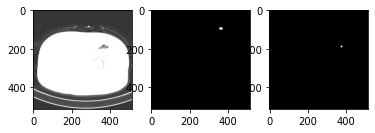

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap='gray')
ax[1].imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), cmap='gray')
mask = target['masks'].mul(255).permute(1, 2, 0).byte().numpy()
print(mask.shape)
mask1 = mask[:,:,0]
for i in range(1, mask.shape[2]):
  mask1 = mask1 + mask[:,:,i]
mask = cv2.cvtColor(mask1, cv2.COLOR_GRAY2RGB)
ax[2].imshow(mask, cmap='gray')
print(target['image_id'])